# Goal & Setup

Here we assess different covariance forms: squared-exponential functions (sometimes called the
radial basis function), nonstationary linear (sometimes called dot-product) functions, and Matern
functions with shape parameters 1/2, 3/2, and 5/2. We also evaluate various combinations of
these functions, and experiment with specifying them along the individual axes of the training
data. See the supplement for more information.

Full analyses with an alternative set of covariances are provided in the "xtimesy" notebooks.

In [1]:
# import the relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# define colormap
plt.set_cmap('viridis')
from lig_utilities import draw_straight_line, train_data_fit
# define the save path for our plots
save_path='./figures/'
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package for GP regression
import gpflow
from lig_utilities import normalize, denormalize, archive_gpflow_model
from datetime import datetime
# import tensorflow so we can save the trained model
import tensorflow as tf

## Load Data

In [4]:
# define the data location
lig_path='./data/lig_data_dec18.pk1'
# load dictionary containing the data
lig_data=pickle.load( open( lig_path, "rb" ) )
# define parameter value grids
crevliq=lig_data['crevliq']
clifvmax=lig_data['clifvmax']

In [5]:
# get the target data at the final time point (the training target points):
ligY_train=np.asarray(lig_data['tais'].tail(1),dtype='float64')
ligY=np.asarray(ligY_train,dtype='float64').reshape(len(clifvmax),len(crevliq))

## Structure Data for Emulation

In [6]:
# Normalize the length scales of the axes
CLIFVMAX_norm=normalize(clifvmax)
CREVLIQ_norm=normalize(crevliq)

In [7]:
# create a meshgrid of the defined parameters and time, and then reshape
xv, yv= np.meshgrid(CLIFVMAX_norm, CREVLIQ_norm, indexing='ij')
nx,ny = len(clifvmax),len(crevliq)

# build the grid on which the data lies for emulation
X_train=np.transpose([yv,xv]).reshape(nx*ny,2)

### Create a sample grid

In [8]:
# define the grid for visualization
sample_crevliq=np.linspace(-0,1.0,50)
sample_clifvmax=np.linspace(-0,1.0,50)
xx, yy = np.meshgrid(sample_clifvmax,sample_crevliq, indexing='ij')
ns1,ns2 = len(sample_clifvmax),len(sample_crevliq)
X_sample=np.transpose([yy,xx]).reshape(ns1*ns2,2)

In [9]:
# denormalize the sample grid
denorm_x=denormalize(sample_clifvmax,np.max(clifvmax),np.min(clifvmax))
denorm_y=denormalize(sample_crevliq,np.max(crevliq),np.min(crevliq))

# Explore CV functions

In [10]:
# Examples we can consider?
# k=gpflow.kernels.RBF(2)
# k=gpflow.kernels.Linear(1,active_dims=[0])+gpflow.kernels.Matern52(1,active_dims=[1])
# k=gpflow.kernels.Linear(1,active_dims=[0])*gpflow.kernels.Matern52(1,active_dims=[0]) \
    #+gpflow.kernels.Linear(1,active_dims=[1])*gpflow.kernels.Matern52(1,active_dims=[1]) \
    #+gpflow.kernels.Matern52(2,active_dims=[0,1])
# k=gpflow.kernels.Matern52(1,active_dims=[0])*gpflow.kernels.Matern52(1,active_dims=[1])+gpflow.kernels.Matern52(2,active_dims=[0,1])

### Squared-Exponential (Isotropic)

In [11]:
# create the model name
model_name='lig_validateCV_RBF'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.RBF(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.RBF(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
# archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -21.555346
  Number of iterations: 22
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -21.555346
  Number of iterations: 22
  Number of functions evaluations: 33


0:00:02.670741


In [12]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_RBF/kern/lengthscales,Parameter,None,+ve,True,(),True,0.2605050535458435
lig_validateCV_RBF/kern/variance,Parameter,None,+ve,True,(),True,7.2728543758154425
lig_validateCV_RBF/likelihood/variance,Parameter,None,+ve,True,(),True,0.015043666178784856


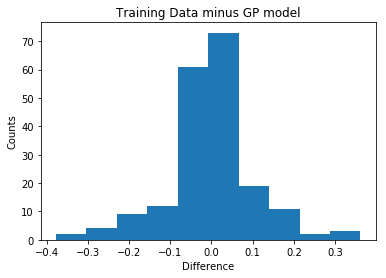

the log likelihood of this model is 21.5553456248


In [13]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

In [14]:
# choose the levels for the plot
min_val,max_val=3.0,6.5
clevels=np.linspace(min_val,max_val,11)

In [15]:
# denormalize the training grid
denorm_points_x=denormalize(X_train[:,1],np.max(clifvmax),np.min(clifvmax))
denorm_points_y=denormalize(X_train[:,0],np.max(crevliq),np.min(crevliq))

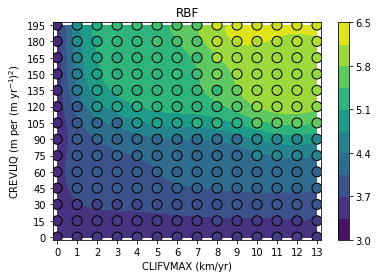

In [16]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
# plot the sample
RBF_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RBF')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

### Linear(x) + Matern(y)

In [17]:
# create the model name
model_name='lig_validateCV_Linx_Mat52y'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Linear(1,active_dims=[0])+gpflow.kernels.Matern52(1,active_dims=[1])
    kernel_code='gpflow.kernels.Linear(1,active_dims=[0])+gpflow.kernels.Matern52(1,active_dims=[1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 89.774329
  Number of iterations: 29
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 89.774329
  Number of iterations: 29
  Number of functions evaluations: 36


0:00:03.310667


In [18]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_Linx_Mat52y/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,5.272744525524882
lig_validateCV_Linx_Mat52y/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.9233548924543746
lig_validateCV_Linx_Mat52y/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,8.297090644809884
lig_validateCV_Linx_Mat52y/likelihood/variance,Parameter,None,+ve,True,(),True,0.12261417774601135


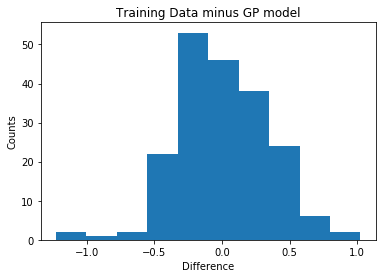

the log likelihood of this model is -89.7743289753


In [19]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

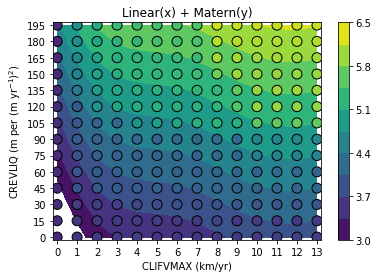

In [20]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
# plot the sample
Linx_Mat52y_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Linear(x) + Matern(y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

### Linear(x) x Matern 5/2(x) + Linear(y) x Matern 5/2(y) + Matern 5/2(x,y)

In [21]:
# create the model name
model_name='lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Linear(1,active_dims=[0])*gpflow.kernels.Matern52(1,active_dims=[0]) \
    +gpflow.kernels.Linear(1,active_dims=[1])*gpflow.kernels.Matern52(1,active_dims=[1]) \
    +gpflow.kernels.Matern52(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.Linear(1,active_dims=[0])*gpflow.kernels.Matern52(1,active_dims=[0]) \
    +gpflow.kernels.Linear(1,active_dims=[1])*gpflow.kernels.Matern52(1,active_dims=[1]) \
    +gpflow.kernels.Matern52(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False
    
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -46.516708
  Number of iterations: 62
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -46.516708
  Number of iterations: 62
  Number of functions evaluations: 73


0:00:08.563097


In [22]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,3.082317823772676
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,2.218170368851904
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,3.0823178231646744
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,7.230512048755491
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,2.2721402409663782
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,7.230512048848831
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,0.19406540544159234
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/kern/kernels/2/variance,Parameter,None,+ve,True,(),True,0.704426448019637
lig_validateCV_LinxMat52x_LinyMat52y_Mat52xy/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


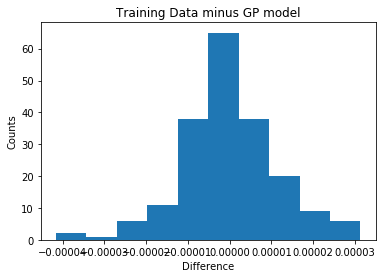

the log likelihood of this model is 46.5167076018


In [23]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

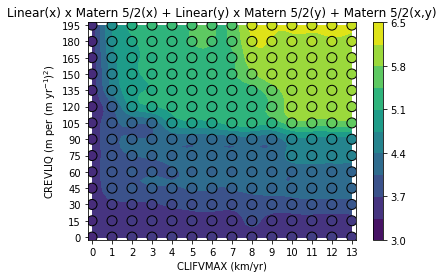

In [24]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
# plot the sample
multiD_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Linear(x) x Matern 5/2(x) + Linear(y) x Matern 5/2(y) + Matern 5/2(x,y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

### Matern1/2(x) x Matern 1/2(y) + Matern 1/2(x,y)

In [25]:
# create the model name
model_name='lig_validateCV_Mat12xMat12y_Mat12xy'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Matern12(1,active_dims=[0])*gpflow.kernels.Matern12(1,active_dims=[1])+gpflow.kernels.Matern12(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.Matern12(1,active_dims=[0])*gpflow.kernels.Matern12(1,active_dims=[1])+gpflow.kernels.Matern12(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)

    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False
    
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -110.060015
  Number of iterations: 54
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -110.060015
  Number of iterations: 54
  Number of functions evaluations: 64


0:00:06.870961


In [26]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_Mat12xMat12y_Mat12xy/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.205627536830824
lig_validateCV_Mat12xMat12y_Mat12xy/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,0.7941221970940338
lig_validateCV_Mat12xMat12y_Mat12xy/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.9833631123858168
lig_validateCV_Mat12xMat12y_Mat12xy/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,0.7941223539899825
lig_validateCV_Mat12xMat12y_Mat12xy/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,770.1935935518388
lig_validateCV_Mat12xMat12y_Mat12xy/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,18.331115364067024
lig_validateCV_Mat12xMat12y_Mat12xy/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


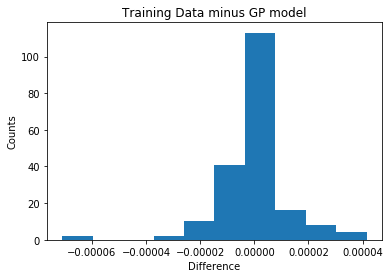

the log likelihood of this model is 110.060014585


In [27]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

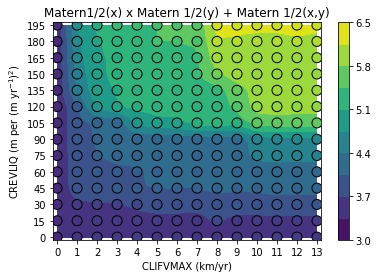

In [28]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
# plot the sample
Times_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Matern1/2(x) x Matern 1/2(y) + Matern 1/2(x,y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

### Matern1/2(x) x Matern 1/2(y)

In [29]:
# create the model name
model_name='lig_validateCV_Mat12xMat12y'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Matern12(1,active_dims=[0])*gpflow.kernels.Matern12(1,active_dims=[1])
    kernel_code='gpflow.kernels.Matern12(1,active_dims=[0])*gpflow.kernels.Matern12(1,active_dims=[1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)

#     m.likelihood.variance = 1e-06
#     m.likelihood.trainable=False
    
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -101.388966
  Number of iterations: 18
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -101.388966
  Number of iterations: 18
  Number of functions evaluations: 21


0:00:04.810087


In [30]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_Mat12xMat12y/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,2.7774628541711546
lig_validateCV_Mat12xMat12y/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.673356061337077
lig_validateCV_Mat12xMat12y/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1.980040879248481
lig_validateCV_Mat12xMat12y/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,1.6733560613345981
lig_validateCV_Mat12xMat12y/likelihood/variance,Parameter,None,+ve,True,(),True,0.0009827166608512173


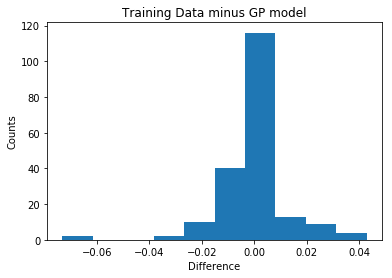

the log likelihood of this model is 101.388965735


In [31]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

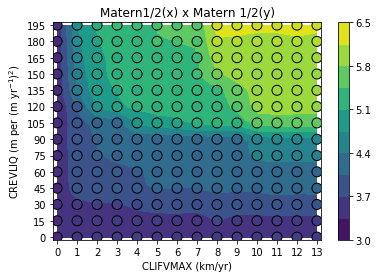

In [32]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
varxy=gpr_var
# plot the sample
Times_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Matern1/2(x) x Matern 1/2(y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

In [33]:
print(np.mean(gpr_var.reshape(ns1,ns2)))
print(np.sqrt(np.mean(gpr_var.reshape(ns1,ns2))))

0.0618970192578
0.248791115713


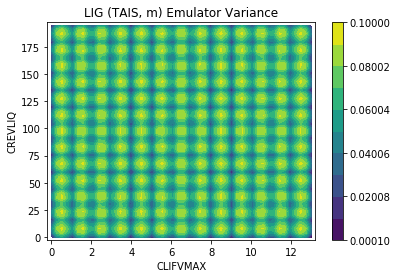

In [34]:
# define the levels
min_val,max_val=0.0001,0.1
np.max(gpr_var.reshape(ns1,ns2))
clevels=np.linspace(min_val,max_val,11)
# plot for the square euclidean distance
plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_var.reshape(ns1,ns2),clevels)
plt.ylabel('CREVLIQ')
plt.xlabel('CLIFVMAX')
plt.title('LIG (TAIS, m) Emulator Variance')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.colorbar(c1)
plt.show()

### Matern 5/2(x,y)

In [35]:
# create the model name
model_name='lig_validateCV_Mat52xy'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Matern52(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.Matern52(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False
    
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -28.153234
  Number of iterations: 24
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -28.153234
  Number of iterations: 24
  Number of functions evaluations: 25


0:00:03.730029


In [36]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_Mat52xy/kern/lengthscales,Parameter,None,+ve,True,(),True,0.31561007795985296
lig_validateCV_Mat52xy/kern/variance,Parameter,None,+ve,True,(),True,5.952736165216159
lig_validateCV_Mat52xy/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


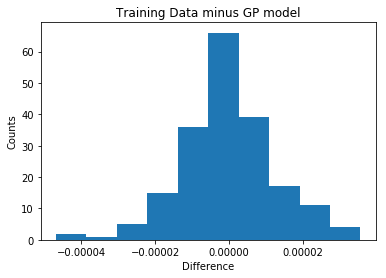

the log likelihood of this model is 28.1532340772


In [37]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

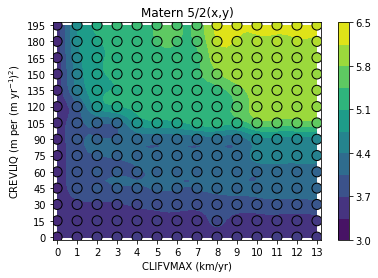

In [38]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
min_val,max_val=3.0,6.5
clevels=np.linspace(min_val,max_val,11)
# plot the sample
Mat52_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Matern 5/2(x,y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

### Matern 1/2(x,y)

In [39]:
# create the model name
model_name='lig_validateCV_Mat12xyadfssa'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Matern12(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.Matern12(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)
    
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -49.445292
  Number of iterations: 21
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -49.445292
  Number of iterations: 21
  Number of functions evaluations: 23


0:00:03.581549


In [40]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_Mat12xyadfssa/kern/lengthscales,Parameter,None,+ve,True,(),True,45.6881863801052
lig_validateCV_Mat12xyadfssa/kern/variance,Parameter,None,+ve,True,(),True,17.045011983228193
lig_validateCV_Mat12xyadfssa/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


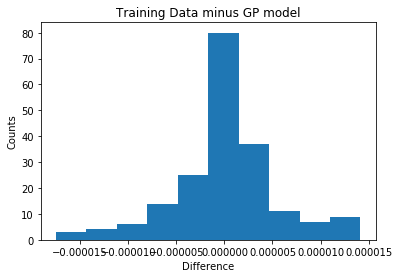

the log likelihood of this model is 49.4452924457


In [41]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

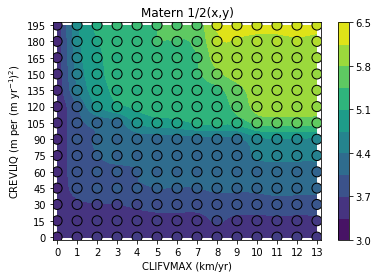

In [42]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
min_val,max_val=3.0,6.5
clevels=np.linspace(min_val,max_val,11)
# plot the sample
Mat12_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Matern 1/2(x,y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

### Matern 3/2(x,y)

In [43]:
# create the model name
model_name='lig_validateCV_Mat32'

# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k=gpflow.kernels.Matern32(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.Matern32(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, ligY_train.reshape(np.size(ligY_train),1), kern=k, name=model_name)
    
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -60.350439
  Number of iterations: 23
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -60.350439
  Number of iterations: 23
  Number of functions evaluations: 25


0:00:04.660923


In [44]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
lig_validateCV_Mat32/kern/lengthscales,Parameter,None,+ve,True,(),True,0.7467072873792986
lig_validateCV_Mat32/kern/variance,Parameter,None,+ve,True,(),True,9.019014634707785
lig_validateCV_Mat32/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


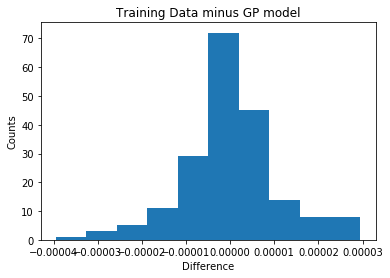

the log likelihood of this model is 60.3504390327


In [45]:
m_fit_range=train_data_fit(m,X_train,ligY_train.reshape(np.size(ligY_train),1))
print('the log likelihood of this model is '+str(m.compute_log_likelihood()))

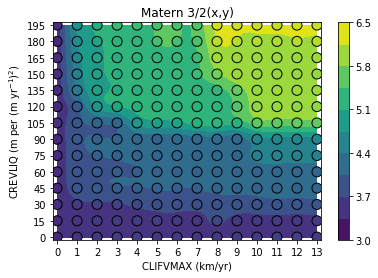

In [46]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)
min_val,max_val=3.0,6.5
clevels=np.linspace(min_val,max_val,11)
# plot the sample
Mat52_mean_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,gpr_mean.reshape(ns1,ns2),clevels)
c2=plt.scatter(denorm_points_x,denorm_points_y,c=np.squeeze(ligY_train),s=100,norm=c1.norm,edgecolors='k')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('Matern 3/2(x,y)')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.colorbar(c1)
plt.show()

# Final Thoughts

There are infinitely many possible model forms, specifications, optimization targets, etc. to
consider for an emulator (Rasmussen and Williams 2006). The final model (described in the
main text of the manuscript, Matern1/2(x,y) above) represents the best model based on several metrics: model simplicity, likelihood maximization, consistency with expectations based on physics, and minimizing of prediction errors (described in Text S2) and model uncertainty (i.e. posterior variance). For RCP8.5 we take Matern5/2 because of the increased smoothness (see **construct_rcp_emulator.ipynb**) and add a time dependant term. Analyses with an alternative set of covariance functions is described in the supplement (and found in the "xtimesy" notebooks in this repository); please see the supplement for more discussion.